# Setup

### Initial tasks

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Imports

In [2]:
# built-ins
import os
import json
from os import path

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
from skompiler import skompile

# training
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Utils / Helpers

In [3]:
def load_json(path):
    with open(path) as f:
        return json.load(f)

### Path Definitions

In [4]:
root = path.abspath(os.getcwd())
dataset_root = path.join(root, 'dataset')

# Read Dataset

In [5]:
def map_employement_duration(entry):
    entry = str(entry).lower()
    split = entry.split(' ')
    num = split[0]
    output = entry
    
    if "-" in num:
        num = num.split("-")[1]
    
    if "weeks" in entry:
        output = float(num) / 52
    elif ("month" in entry) or ("ay" in entry):
        output = float(num) / 12
    elif ("years" in entry) or ("sene" in entry) or ("yıl" in entry):
        output = float(num)
    else:
        try:
            output = float(num)
        except:
            output = 0
        
    output = round(output, 3)
    return output

In [6]:
# read encodings
encodings = load_json(path.join(dataset_root, 'encodings.json'))

# read csvs
csv_en = pd.read_csv(path.join(dataset_root, 'csv/english.csv'), dtype=str)
csv_tr = pd.read_csv(path.join(dataset_root, 'csv/turkish.csv'), dtype=str)

# drop columns
csv_en.drop('Timestamp', axis=1, inplace=True)
csv_tr.drop('Timestamp', axis=1, inplace=True)

# rename columns
csv_en.rename(columns=encodings['columns']['en'], inplace=True)
csv_tr.rename(columns=encodings['columns']['tr'], inplace=True)

# encode columns
csv_en.replace(encodings['values']['en'], inplace=True)
csv_tr.replace(encodings['values']['tr'], inplace=True)

# concat csvs
df = pd.concat([csv_en, csv_tr], axis=0)

# fix NaNs
df.fillna(0, inplace=True)

# convert types
df['age'] = df['age'].apply(lambda x: int(x))
df['weight'] = df['weight'].apply(lambda x: int(float(x.replace(',', '.'))))
df['height'] = df['height'].apply(lambda x: int(x.translate({ord(x): '' for x in [',', '.', ' ']})))
df['employment_duration'] = df['employment_duration'].apply(map_employement_duration)

# save csv
df.to_csv(path.join(dataset_root, 'csv/data.csv'), index=None, header=True, encoding='utf-8-sig')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 309
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  322 non-null    int64  
 1   height               322 non-null    int64  
 2   weight               322 non-null    int64  
 3   gender               322 non-null    int64  
 4   smoking              322 non-null    int64  
 5   drinking             322 non-null    int64  
 6   exercise             322 non-null    int64  
 7   married              322 non-null    int64  
 8   children             322 non-null    int64  
 9   student              322 non-null    int64  
 10  employed             322 non-null    int64  
 11  employment_duration  322 non-null    float64
dtypes: float64(1), int64(11)
memory usage: 32.7 KB


# Explatory Data Analysis

In [7]:
df.head()

,age,height,weight,gender,smoking,drinking,exercise,married,children,student,employed,employment_duration
0,36,175,82,1,0,3,1,0,0,0,1,12.000
1,22,178,77,1,0,2,1,0,0,1,0,0.000
2,32,174,65,1,0,2,1,0,0,1,2,0.038
3,21,156,65,0,0,0,2,0,0,1,0,0.000
4,24,176,94,1,0,1,1,0,0,1,0,0.000


# Hyperparameters

In [8]:
hp_seed = 42

hp_split_seed = hp_seed
hp_test_size = 0.2
hp_val_size = 0.1

# Preprocessing

### Helpers

In [9]:
def remove_outliers(dframe, columns):
    for column in columns:
        Q1 = dframe[column].quantile(0.25)
        Q3 = dframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_band = Q1 - 1.5*IQR
        upper_band = Q3 + 1.5*IQR
        
        normals = ~((dframe[column] < lower_band) | (dframe[column] > upper_band))
        dframe = dframe.loc[normals]
    
    return dframe

### Pipeline

In [10]:
# Split into test, val and train.
rest_df, test_df = train_test_split(df, test_size=hp_test_size, random_state=hp_split_seed)
train_df, val_df = train_test_split(rest_df, test_size=hp_val_size, random_state=hp_split_seed)

# Remove outliers from train.
# train_df = remove_outliers(train_df, ['age', 'height', 'weight'])
print(train_df.shape)

# Apply standardization
cols = ['age', 'height', 'employment_duration']
std_scaler = preprocessing.StandardScaler().fit(train_df[cols])
test_df[cols] = std_scaler.transform(test_df[cols])
val_df[cols] = std_scaler.transform(val_df[cols])
train_df[cols] = std_scaler.transform(train_df[cols])

# Separate data and labels.
X_test, Y_test = test_df.drop('weight', axis=1), test_df['weight'].to_frame()
X_val, Y_val = val_df.drop('weight', axis=1), val_df['weight'].to_frame()
X_train, Y_train = train_df.drop('weight', axis=1), train_df['weight'].to_frame()

(231, 12)


# Training

### Helpers

In [18]:
def process_pred(true, pred):
    if type(true) is pd.DataFrame:
        true = true.to_numpy()
        
    if type(pred) is pd.DataFrame:
        pred = pred.to_numpy()
        
    true = true.reshape(-1)
    pred = pred.reshape(-1)
    
    rmse = round(np.sqrt(mean_squared_error(true, pred)), 2)
    diff = np.absolute(true - pred)
        
    df = pd.DataFrame(data={
        'true': true,
        'prediction': pred,
        'diff': diff
    })
    
    df = df.sort_values('diff', ascending=False)
    
    return df, rmse

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (5018081.py, line 33)

## Linear Regression

In [12]:
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)

rdf, rmse = process_pred(Y_test, Y_pred)
print(rmse)
rdf.head(10)

LinearRegression()

9.84


,true,prediction,diff
26,100,64.443950,35.556050
37,55,80.256014,25.256014
41,105,83.577135,21.422865
23,91,72.894773,18.105227
29,54,71.675001,17.675001
38,80,97.262309,17.262309
59,97,80.881289,16.118711
22,47,62.977079,15.977079
57,65,51.017552,13.982448
43,60,73.863599,13.863599


## Linear Support Vector Regression

In [13]:
svr_model = LinearSVR(random_state=hp_seed)
svr_model.fit(X_train, Y_train.to_numpy().ravel())
Y_pred = svr_model.predict(X_test)

rdf, rmse = process_pred(Y_test, Y_pred)
print(rmse)
rdf.head(10)

LinearSVR(random_state=42)

12.03


,true,prediction,diff
26,100,64.489839,35.510161
44,70,41.519885,28.480115
47,91,65.455192,25.544808
50,90,64.591616,25.408384
59,97,72.221168,24.778832
41,105,83.965775,21.034225
63,87,67.200543,19.799457
34,62,79.395954,17.395954
18,50,32.908454,17.091546
36,84,67.460121,16.539879


## Decision Tree

In [20]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, Y_train)
Y_pred = dt_model.predict(X_test)

rdf, rmse = process_pred(Y_test, Y_pred)
print(rmse)
rdf.head(10)

#print(skompile(dt_model.predict).to('string'))

DecisionTreeRegressor()

15.71


,true,prediction,diff
49,81,130.0,49.0
4,62,100.0,38.0
27,72,100.0,28.0
42,74,100.0,26.0
41,105,80.0,25.0
10,78,53.0,25.0
57,65,41.0,24.0
5,76,53.0,23.0
45,86,108.0,22.0
48,68,89.0,21.0


## Random Forest

RandomForestRegressor(random_state=42)

11.55


,true,prediction,diff
26,100,59.720000,40.280000
41,105,80.720000,24.280000
22,47,67.900000,20.900000
64,56,75.970000,19.970000
43,60,77.846667,17.846667
59,97,80.120000,16.880000
55,75,58.600000,16.400000
19,75,58.890000,16.110000
37,55,71.110000,16.110000
47,91,74.950000,16.050000


[0.22355739 0.42948967 0.03298155 0.03544098 0.0521709  0.03895918
 0.03701942 0.00713196 0.0092897  0.04803501 0.08592424]


<BarContainer object of 11 artists>

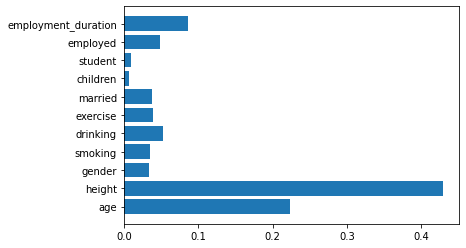

In [15]:
rf_model = RandomForestRegressor(random_state=hp_seed)
rf_model.fit(X_train, Y_train.to_numpy().ravel())
Y_pred = rf_model.predict(X_test)

rdf, rmse = process_pred(Y_test, Y_pred)
print(rmse)
rdf.head(10)

print(rf_model.feature_importances_)
plt.barh(X_train.columns, rf_model.feature_importances_)

## XGBoost

In [16]:
xgb_model = XGBRegressor(random_state=hp_seed)
xgb_model.fit(X_train, Y_train.to_numpy().ravel())
Y_pred = xgb_model.predict(X_test)

rdf, rmse = process_pred(Y_test, Y_pred)
print(rmse)
rdf.head(10)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

12.17


,true,prediction,diff
26,100,66.609558,33.390442
36,84,59.797592,24.202408
64,56,79.140701,23.140701
13,53,73.296059,20.296059
59,97,76.779999,20.220001
18,50,68.705338,18.705338
41,105,86.475693,18.524307
17,51,69.342911,18.342911
10,78,60.005642,17.994358
47,91,73.185051,17.814949


## LGBM

In [17]:
lgbm_model = LGBMRegressor(random_state=hp_seed)
lgbm_model.fit(X_train, Y_train.to_numpy().ravel())
Y_pred = lgbm_model.predict(X_test)

rdf, rmse = process_pred(Y_test, Y_pred)
print(rmse)
rdf.head(10)

LGBMRegressor(random_state=42)

10.56


,true,prediction,diff
26,100,61.692235,38.307765
47,91,69.950645,21.049355
43,60,78.595125,18.595125
37,55,73.559969,18.559969
41,105,86.641456,18.358544
63,87,69.595272,17.404728
23,91,74.796900,16.203100
59,97,80.813263,16.186737
22,47,63.033873,16.033873
57,65,50.011238,14.988762
